## Qiskit quantum neural network (QNN) tutorial
In this notebook, we implement a quantum neural network (QNN) for a data classification task. Our dataset consists of images containing horizontal and vertical stripes, and our goal is to label unseen images into one of the two categories depending on the orientation of their line. As the ansatz of our QNN, we specifically construct a [quantum convolutional neural network](https://www.nature.com/articles/s41567-019-0648-8) (QCNN). For data generation and ansatz construction, we follow the strategy found [here](https://qiskit-community.github.io/qiskit-machine-learning/tutorials/11_quantum_convolutional_neural_networks.html).

### Data generation
We start by randomly generating a dataset consisting of 2x4 images with horizontal and vertical lines. Images with horizontal lines are labeled -1 and vertical with +1.

In [1]:
import numpy as np 


size = 16
vert_size = 4
line_size = 4

def generate_dataset(num_images):
    images = []
    labels = []
    hor_array = np.zeros((size-(line_size-1)*vert_size, size))
    ver_array = np.zeros((round(size/vert_size)*(vert_size-line_size+1), size))
    #CP: 6 row 8 column matrix. The rows will get 2 adjacent entries filled, then we select. 4 row 8 column, similar but with vertically stacked fillings.
    
    j = 0
    for i in range(0, size-1):
        if i%((size/vert_size)) <= ((size/vert_size))-line_size:
            for p in range(0,line_size):
                hor_array[j][i+p] = np.pi / 2
            j += 1
  
    #CP: Make two adjacent entries pi/2, then move down to the next row. Except don't do that at the half-way point, because we want to fold this into a grid.
    
    j = 0
    for i in range(0, round(size/vert_size)*(vert_size-line_size+1)):
        for p in range(0,line_size):
            ver_array[j][i + p*round(size/vert_size)] = np.pi / 2
        j += 1

    #CP: Make entries pi/2, spaced by the length/2, so that when folded, the entries appear on top of each other.

    for n in range(num_images):
        rng = np.random.randint(0, 2)
        if rng == 0:
            labels.append(-1)
            random_image = np.random.randint(0, len(hor_array))
            images.append(np.array(hor_array[random_image]))
            #CP: Randomply select one of the 6 rows you made in the horizontal (6x8) matrix above.
        elif rng == 1:
            labels.append(1)
            random_image = np.random.randint(0, len(ver_array))
            images.append(np.array(ver_array[random_image]))
            #CP: Randomply select one of the 4 rows you made in the vertical (4x8) matrix above.

        # Create noise
        for i in range(size):
            if images[-1][i] == 0:
                images[-1][i] = np.random.rand() * np.pi / 4
    return images, labels

We split the generated data into training and test sets.

In [2]:
from sklearn.model_selection import train_test_split

np.random.seed(42)
images, labels = generate_dataset(50)

train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=246
)

hor_size = round(size/vert_size)

We can now display some images from the dataset with horizontal or vertical lines.

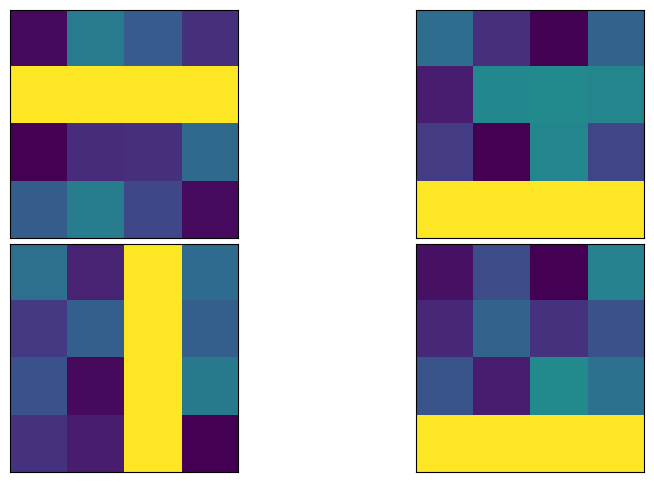

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(10, 6), subplot_kw={"xticks": [], "yticks": []})
for i in range(4):
    ax[i // 2, i % 2].imshow(
        train_images[i].reshape(vert_size, hor_size),  # Change back to 2 by 4
        aspect="equal",
    )
plt.subplots_adjust(wspace=0.1, hspace=0.025)

### Defining the neural network ansatz
As mentioned previously, our ansatz is a quantum convolutional neural network (QCNN), consisting of alternating convolutional and pooling layers. 

We start by constructing the parametric two-qubit unitary which will be the building block of the convolutional layer. As a design choice, we implement these convolutional circuits as the 3-parameter gate set found in between the CNOT gate blocks of the [KAK decomposition](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.69.032315).

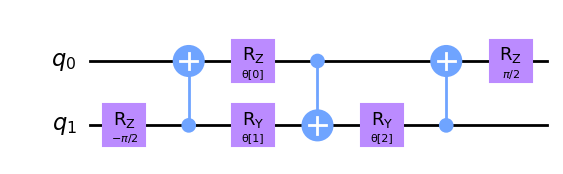

In [4]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector


def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target


# Display the convolutional circuit
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl", style="clifford")

The convolutional layer consists of these two-qubit unitaries laid out in non-overlapping nearest-neighbor topology in 2 layers as defined below.

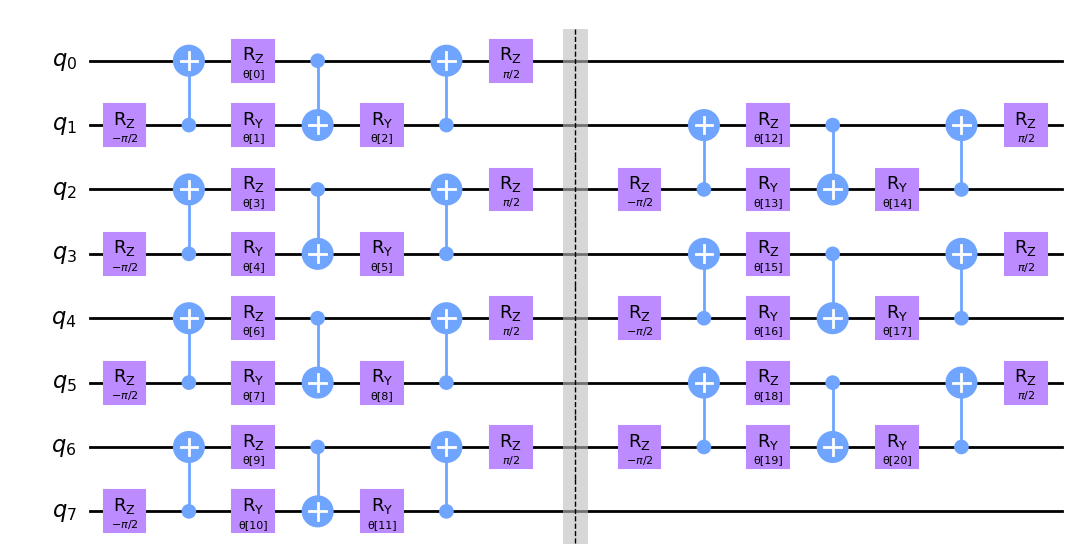

In [5]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        param_index += 3
    qc.barrier()
    for q1, q2 in zip(qubits[1::2], qubits[2::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


# Display the convolutional layer for an example of 8 qubits
circuit = conv_layer(8, "θ")
circuit.decompose().draw("mpl", style="clifford")

The pooling layer also consists of two-qubit unitaries, which we choose to design with 3 parameters as below.

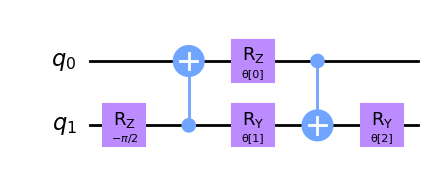

In [6]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


# Display the pooling circuit
params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl", style="clifford")

When putting the pooling layer together, we connect a pair of qubits with the two-qubit unitaries defined above. Then we trace out one of the qubits per pooling circuit block, i.e. we discard half of the qubits in the entire pooling layer and effectively reduce the system size by half.

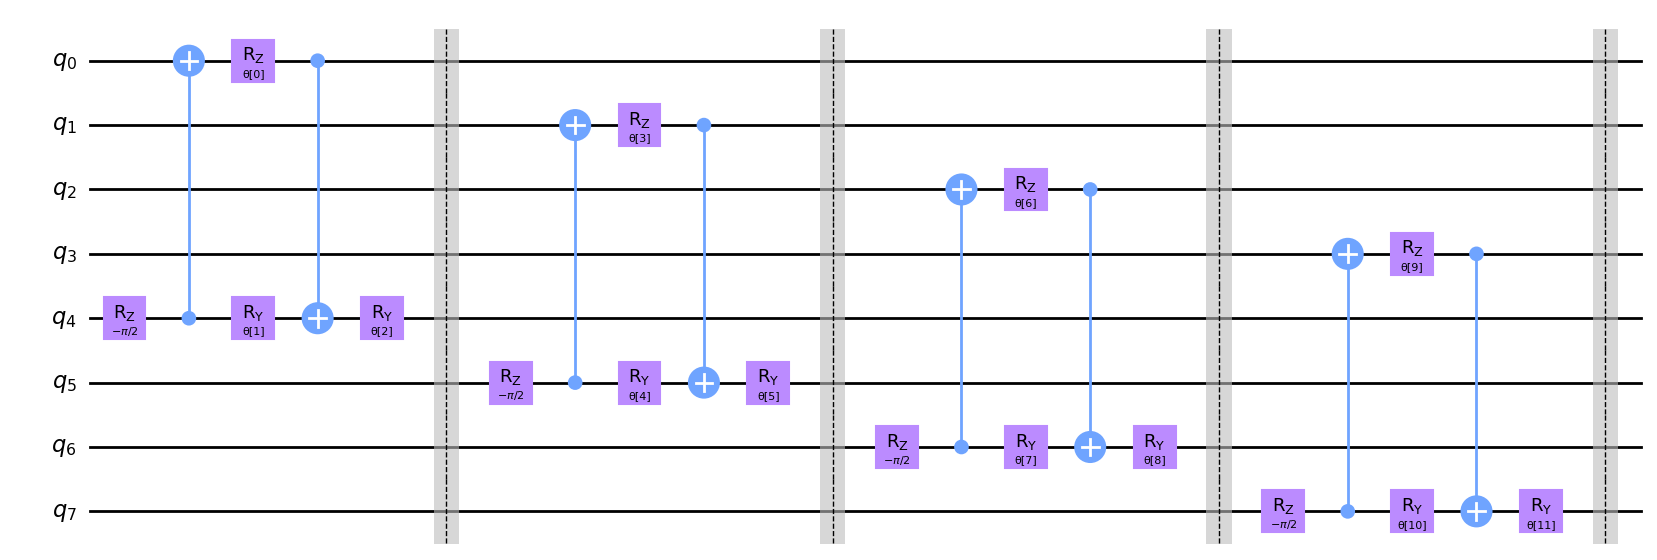

In [7]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


# Display the pooling layer with an example of 8 qubits, where source qubits are discarded afterwards
sources = [0, 1, 2, 3]
sinks = [4, 5, 6, 7]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl", style="clifford")

## Qiskit Patterns Step 1: Mapping the problem to quantum circuits
We are now ready to build the whole quantum circuit, which consists of a feature map to encode the data onto the quantum computer followed by the quantum convolutional neural network ansatz.

In [8]:
def get_qcnn_ansatz(num_qubits: int) -> QuantumCircuit:
    """
    Creates the quantum convolutional neural network (QCNN) ansatz.

    Args:
        num_qubits: number of qubits in the circuit.

    Returns:
        ansatz: QCNN ansatz as a QuantumCircuit object.
    """
    ansatz = QuantumCircuit(num_qubits, name="Ansatz")

    # Convolutional layer acts on "full_qubits" number of qubits
    # Pooling layer reduces "full_qubits" number of qubits to "half_qubits" number of qubits
    # If "full_qubits" is odd, take the larger half to ensure last pooling layer has 2->1 qubits
    full_qubits = num_qubits
    half_qubits = (num_qubits + 1) // 2

    # Add convolutional and pooling layers until there is only one qubit left for binary classification
    layer = 1
    pool_until = 1
    while full_qubits > pool_until:
        # Convolutional Layer
        ansatz.compose(conv_layer(num_qubits=full_qubits, 
                                  param_prefix=f"c{layer}"),
                       list(range(num_qubits - full_qubits, num_qubits)),
                       inplace=True)
        
        # Pooling Layer
        ansatz.compose(pool_layer(sources=list(range(0, half_qubits)),
                                  sinks=list(range(half_qubits, full_qubits)),
                                  param_prefix=f"p{layer}"),
                       list(range(num_qubits - full_qubits, num_qubits)),
                       inplace=True)

        full_qubits = half_qubits
        half_qubits = (half_qubits + 1) // 2
        layer += 1
    
    return ansatz

We encode the data onto the quantum computer using the Z Feature Map. This method uses one qubit per data feature, i.e. per pixel in this case. Then we add convolutional and pooling layers in an alternating fashion until we are left with a single qubit in the circuit. This is because we have a binary classification task and measuring a single qubit is sufficient to classify data into one of the two labels. 

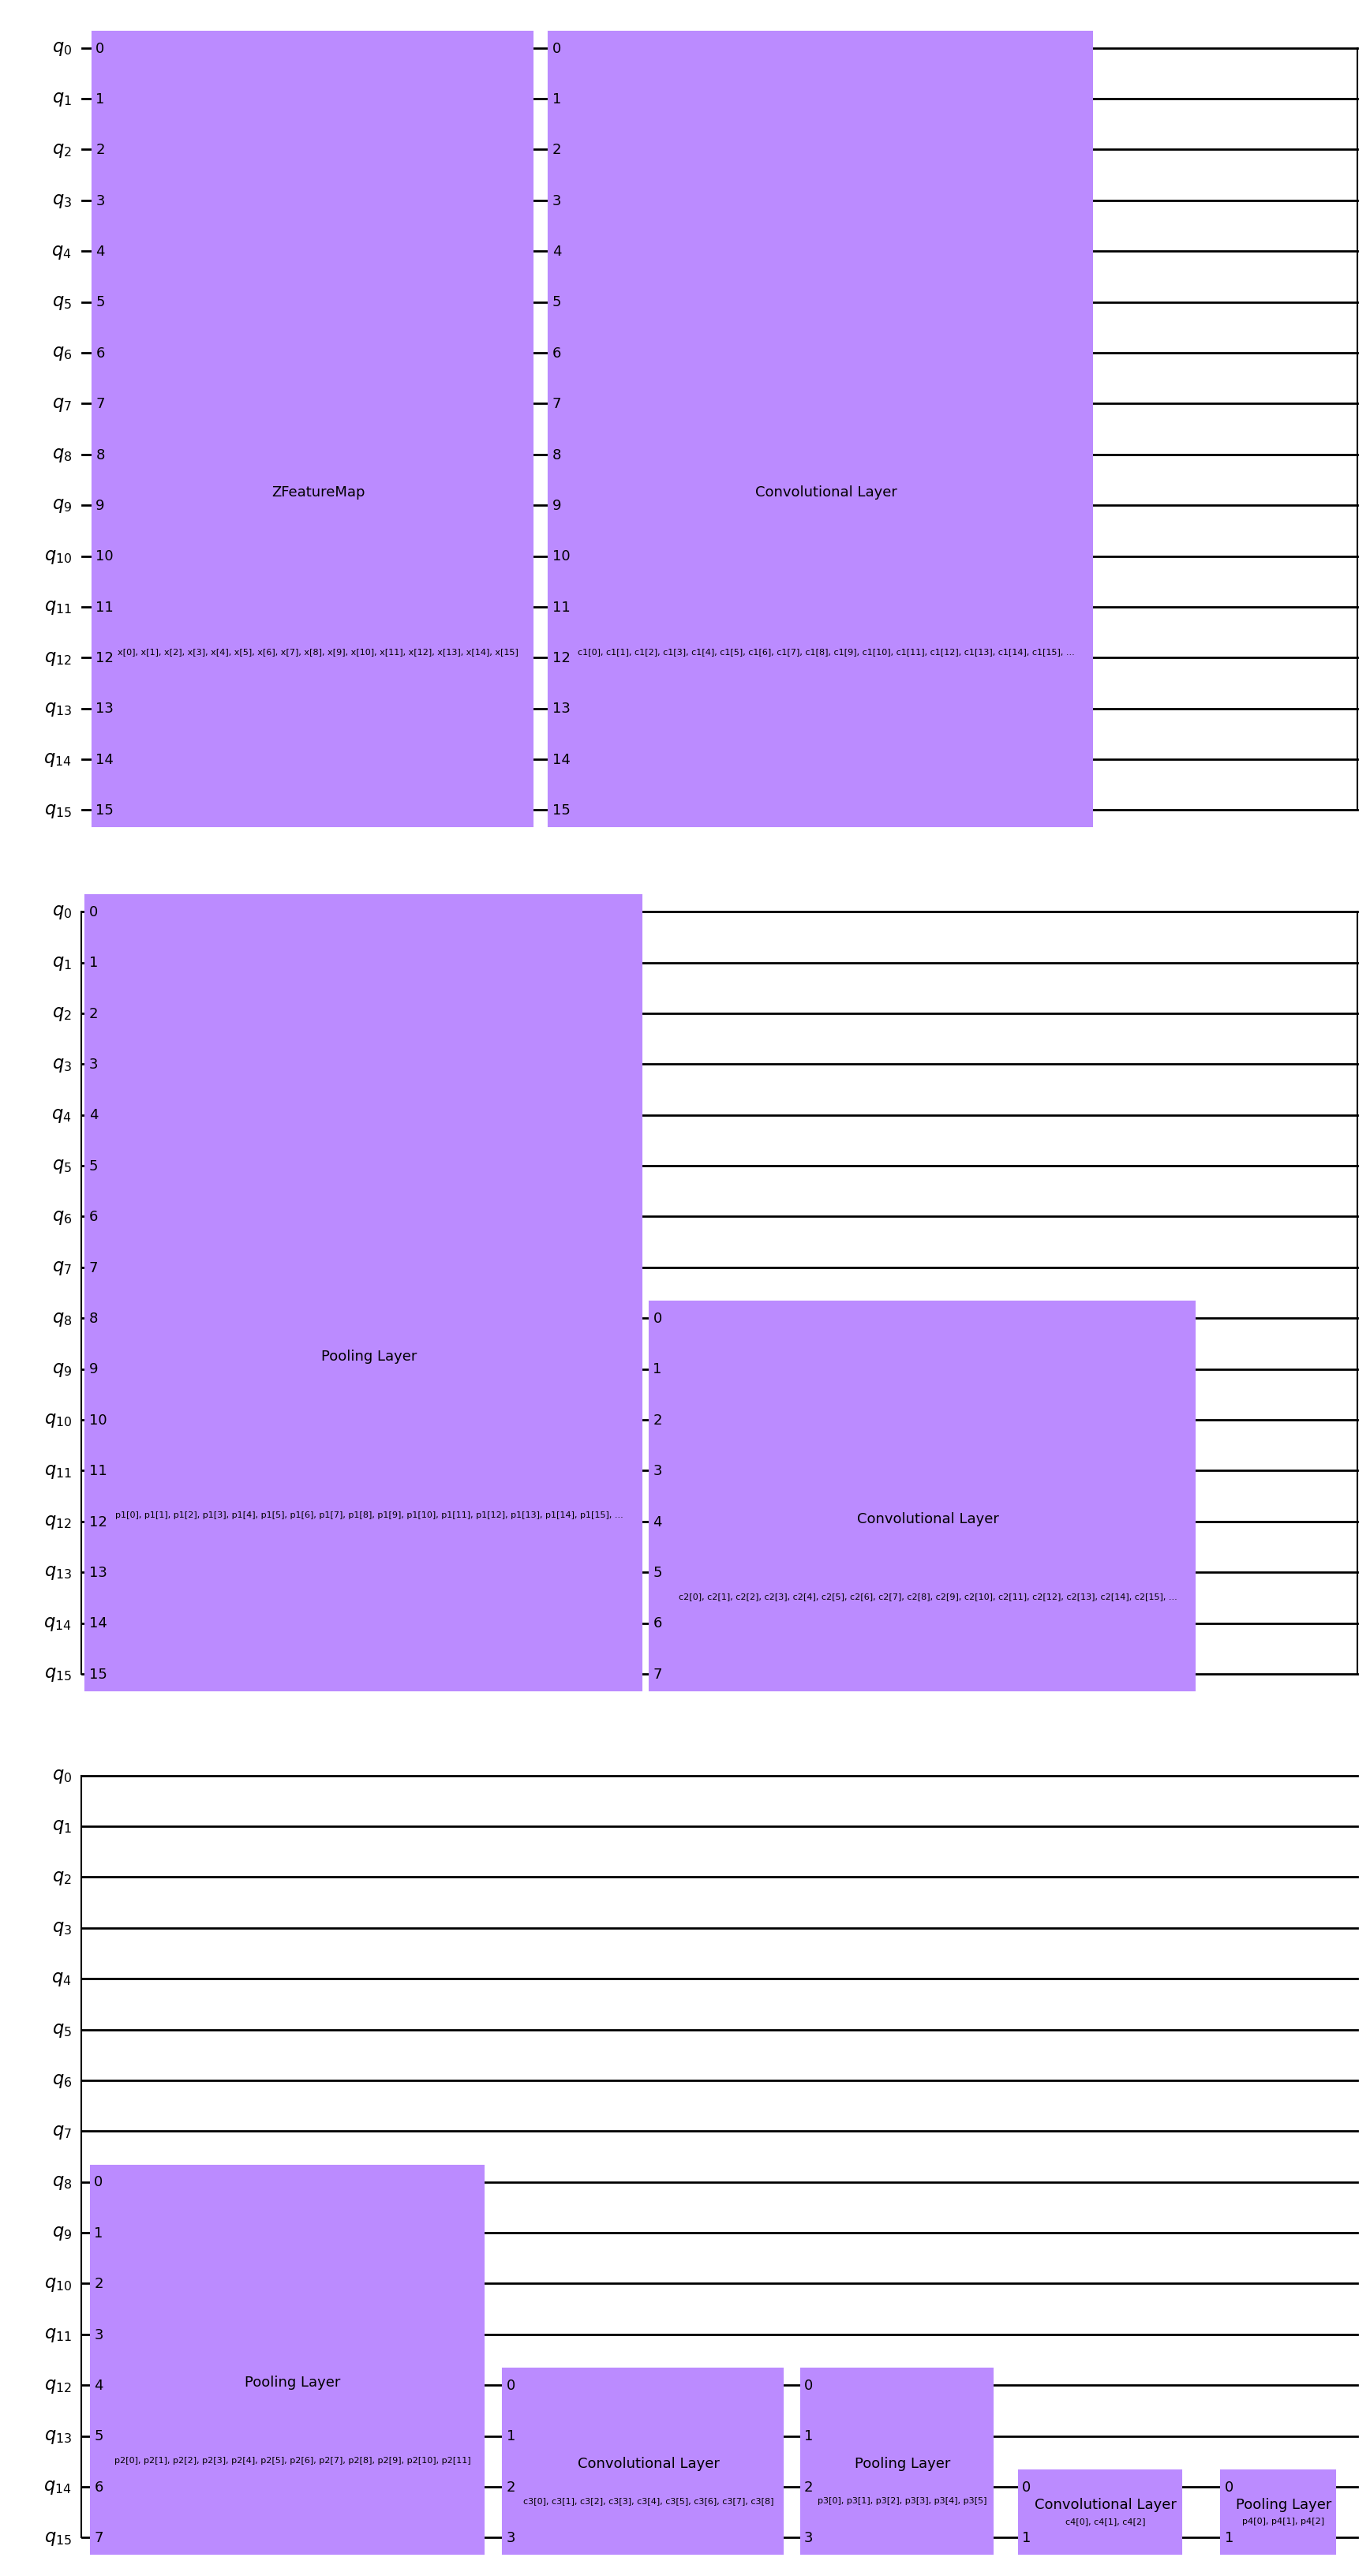

In [9]:
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp

# One qubit per data feature
num_qubits = len(train_images[0])

# Data encoding
feature_map = ZFeatureMap(num_qubits)

# QCNN ansatz
ansatz = get_qcnn_ansatz(num_qubits)

# Combine the feature map with the ansatz
circuit = QuantumCircuit(num_qubits)
circuit.compose(feature_map, range(num_qubits), inplace=True)
circuit.compose(ansatz, range(num_qubits), inplace=True)

# Display the circuit
circuit.draw("mpl", style="clifford")

Our observable is the Pauli-Z operator on the last qubit. 

In [10]:
observable = SparsePauliOp.from_list([("Z" + "I" * (num_qubits - 1), 1)])

Before we optimize the circuit for a run on quantum hardware, we test the code on the simulator for small problem sizes. We define functions to run and train the circuit below.

### Load the data and do a forward pass
We write a function to do one forward pass of the quantum neural network. Then we test it with a small batch from the dataset and randomly initialized ansatz parameters.

In [11]:
from qiskit.primitives import BaseEstimatorV2
from qiskit.quantum_info.operators.base_operator import BaseOperator
from typing import Sequence


def forward(circuit: QuantumCircuit,
            input_params: np.ndarray, 
            weight_params: np.ndarray, 
            estimator: BaseEstimatorV2,
            observables: Sequence[BaseOperator] | BaseOperator
) -> np.ndarray:
    """
    Forward pass of the neural network.
    
    Args:
        circuit: circuit consisting of data loader gates and the neural network ansatz.
        input_params: data encoding parameters.
        weight_params: neural network ansatz parameters.
        estimator: EstimatorV2 primitive. 
        observables: a single oberservable or a sequence of observables to compute the expectation over.

    Returns:
        expectation_values: an array (for one observable) or a matrix (for a sequence of observables) of expectation values.
        Rows correspond to observables and columns to data samples.
    """
    num_samples = input_params.shape[0]
    weights = np.broadcast_to(weight_params, (num_samples, len(weight_params)))
    params = np.concatenate((input_params, weights), axis=1)
    pub = (circuit, observables, params)
    job = estimator.run([pub])
    result = job.result()[0]
    expectation_values = result.data.evs

    return expectation_values

This step takes one example training picture, and does a single forward pass. It then returns the expectation value.

Below is an example forward pass with two images from the dataset and randomly initialized ansatz parameters.

In [12]:
#Skip for large runs; just for benchmarking and education
from qiskit.primitives import StatevectorEstimator as Estimator

np.random.seed(42)

result = forward(circuit=circuit, 
                 input_params=np.array(train_images[:2]), 
                 weight_params=np.random.rand(len(ansatz.parameters)) * 2 * np.pi, 
                 estimator=Estimator(), 
                 observables=[observable])
print(result)

[-0.00753625 -0.0108826 ]


### Computing gradients with the parameter shift rule
We implement one example gradient evaluation of the expectation values using the [parameter shift rule](https://doi.org/10.1103/PhysRevA.99.032331), to be used with gradient-based optimizers. 
When using a gradient-free optimizer such as COBYLA, we can omit this function.

In [13]:
def param_shift_estimator_gradient(circuit: QuantumCircuit,
                                   input_params: np.ndarray, 
                                   weight_params: np.ndarray, 
                                   estimator: BaseEstimatorV2,
                                   observables: BaseOperator
) -> np.ndarray:
    """
    Compute the gradients of the expectation values using the parameter shift rule.

    Args:
        circuit: circuit consisting of data loader gates and the neural network ansatz.
        input_params: data encoding parameters.
        weight_params: neural network ansatz parameters.
        estimator: EstimatorV2 primitive. 
        observables: a single oberservable or a sequence of observables to compute the expectation over.

    Returns:
        gradients: list of expectation value gradients with respect to weight parameters.
        Columns correspond to weight parameters, and rows to different inputs.
    """
    num_samples = input_params.shape[0]
    num_weight_params = len(weight_params)

    weights = np.broadcast_to(weight_params, (num_samples * num_weight_params, num_weight_params))
    inputs  = np.tile(input_params, (num_weight_params, 1))

    weights_plus = weights.copy()
    for j in range(num_weight_params):
        for i in range(num_samples):
            weights_plus[j * num_samples + i][j] = weight_params[j] + np.pi / 2 

    weights_minus = weights.copy()
    for j in range(num_weight_params):
        for i in range(num_samples):
            weights_minus[j * num_samples + i][j] = weight_params[j] - np.pi / 2 

    params_plus = np.concatenate((inputs, weights_plus), axis=1)
    params_minus = np.concatenate((inputs, weights_minus), axis=1)

    pub_plus = (circuit, observables, params_plus)
    pub_minus = (circuit, observables, params_minus)

    job = estimator.run([pub_plus, pub_minus])

    result_plus = job.result()[0]
    result_minus = job.result()[1]

    expectation_values_plus = result_plus.data.evs
    expectation_values_minus = result_minus.data.evs

    gradients = (expectation_values_plus - expectation_values_minus) / 2
    gradients = np.array(gradients).reshape((num_weight_params, num_samples)).T
    
    return gradients

We compute the gradients for all ansatz parameters for two images from the dataset.

???CP: This appears to never be used again after this. Must switch to a different optimizer that takes pre-calculated gradients???

In [14]:
#Skip for large runs; just for benchmarking and education
#np.random.seed(12345)

#input_params = np.array([train_images[0], train_images[1]])
#weight_params = np.random.rand(len(ansatz.parameters)) * 2 * np.pi
#estimator = Estimator()
#observables = [observable]

#result = param_shift_estimator_gradient(circuit, input_params, weight_params, estimator, observables)
#print(result)

### Loss function
Now we define the loss function that will be minimized during training. For this example, we implement the mean squared error (MSE) loss function.

In [15]:
def mse_loss(predict: np.ndarray, target: np.ndarray) -> np.ndarray:
    """
    Mean squared error (MSE).

    prediction: predictions from the forward pass of neural network.
    target: true labels.

    output: MSE loss.
    """
    if len(predict.shape) <= 1:
        return ((predict - target) ** 2).mean()
    else:
        return (np.linalg.norm(predict - target, axis=tuple(range(1, len(predict.shape)))) ** 2).mean()

Below is an example run of the loss function.

This takes just two training images, takes the true labels and predictions and determines the loss.

In [16]:
#Skip for large runs; just for benchmarking and education
#batch_size = 20
#train_images_batch = np.array(train_images[:batch_size])
#train_labels_batch = np.array(train_labels[:batch_size])
#print(f"True labels: {train_labels_batch}")

#np.random.seed(42)

#pred_batch = forward(circuit=circuit, 
#                     input_params=train_images_batch, 
#                     weight_params=np.random.rand(len(ansatz.parameters)) * 2 * np.pi,
#                     estimator=Estimator(),
#                     observables=observable)
#print(f"Predictions: {pred_batch}")

#loss = mse_loss(predict=pred_batch, target=train_labels_batch)
#print(f"Loss: {loss}")

### Cost function
We now define the cost function that will be provided to the optimizer. This function only takes the ansatz parameters as input; other variables for the forward pass and the loss are set as global parameters.

In [17]:
def cost_function(weight_params: np.ndarray) -> np.ndarray:
    """
    Cost function for the optimizer to update the ansatz parameters.

    weight_params: ansatz parameters to be updated by the optimizer.

    output: MSE loss.
    """
    predictions = forward(circuit=circuit, 
                          input_params=input_params, 
                          weight_params=weight_params, 
                          estimator=estimator, 
                          observables=observables)
    
    cost = mse_loss(predict=predictions, target=target)
    objective_func_vals.append(cost)
    
    global iter
    if iter % 50 == 0:
        print(f"Iter: {iter}, loss: {cost}")
    iter += 1

    return cost

We set the initial variables for the cost function.

In [18]:
#Skip for large runs; just for benchmarking and education

# Globals
#circuit = circuit
#input_params = train_images_batch
#estimator = Estimator()
#observables = observable
#target = train_labels_batch
#objective_func_vals = []
#iter = 0

Below is an example run of the cost function.

In [19]:
#Skip for large runs; just for benchmarking and education
#np.random.seed(42)
#weight_params = np.random.rand(len(ansatz.parameters)) * 2 * np.pi
#cost_function(weight_params)

### Optimizer
Now we run the optimizer once for a small batch from the training data. We use the COBYLA method for minimization in this example.

In [20]:
from scipy.optimize import minimize

In [21]:
#Skip for large runs; just for benchmarking and education

#from scipy.optimize import minimize

#res = minimize(cost_function, weight_params, method='COBYLA', options={'maxiter': 20})
#print(res)

We run a forward pass with the learned parameters to see accuracy over the small training batch.

In [22]:
#Skip for large runs; just for benchmarking and education

#print(f"Learned weights: {res['x']}")
#pred_batch = forward(circuit, train_images_batch, res['x'], estimator, observable)
#print(f"Forward pass expectations: {pred_batch}")

Since this is a classification task, we use the mean value 0 of the class labels as the cutoff value.

In [23]:
import copy

In [24]:
#Skip for large runs; just for benchmarking and education

#import copy

#pred_labels_batch = copy.deepcopy(pred_batch)
#pred_labels_batch[pred_labels_batch >= 0] = 1
#pred_labels_batch[pred_labels_batch < 0] = -1

#print(f"Predicted labels: {pred_labels_batch}")
#print(f"True labels: {train_labels_batch}")

## Qiskit Patterns Step 2: Optimize problem for quantum execution

We start by selecting a backend for execution.

In [26]:
from qiskit_ibm_runtime import QiskitRuntimeService

 
# Optional: List all the instances you can access.
#service = QiskitRuntimeService(channel='ibm_quantum')
#print(service.instances())
 
# Optional: Specify it at service level. This becomes the default unless overwritten.
service = QiskitRuntimeService(channel='ibm_quantum', instance="client-enablement/content/qal-20")

#service = QiskitRuntimeService(channel="ibm_quantum", instance="ibm-q/open/main")
backend = service.least_busy(operational=True, simulator=False, min_num_qubits = 127)
print(backend.name)

ibm_kyoto


Here we optimize the circuit for running on a real backend by specifying the optimization_level and adding dynamical decoupling. The code below generates a mass manager using preset pass managers from qiskit.transpiler.

In [27]:
from qiskit.circuit.library import XGate
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import (
    ALAPScheduleAnalysis,
    ConstrainedReschedule,
    PadDynamicalDecoupling,
)
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
pm.scheduling = PassManager(
    [
        ALAPScheduleAnalysis(target=target),
        ConstrainedReschedule(target.acquire_alignment, target.pulse_alignment),
        PadDynamicalDecoupling(
            target=target, dd_sequence=[XGate(), XGate()], pulse_alignment=target.pulse_alignment
        ),
    ]
)

Now we use the pass manager on the initial state. We can similarly apply device layout characteristics to the observable to get a more physical representation.

In [28]:
circuit_ibm = pm.run(circuit)
observable_ibm = observable.apply_layout(circuit_ibm.layout)

In [29]:
circuit_ibm.depth()

733

In [30]:
from qiskit.transpiler import TranspileLayout

In [31]:
#updated ops&depth on cusco
print(circuit_ibm.depth())
print(dict(circuit_ibm.count_ops()))

733
{'rz': 1242, 'delay': 896, 'sx': 620, 'x': 475, 'ecr': 235, 'barrier': 19}


In [239]:
#current best ops&depth on cusco
circuit_ibm.depth()
print(dict(circuit_ibm.count_ops()))
circuit_ibm.layout._output_qubit_list

{'rz': 1153, 'delay': 853, 'sx': 568, 'x': 450, 'ecr': 211, 'barrier': 19}


[Qubit(QuantumRegister(127, 'q'), 0),
 Qubit(QuantumRegister(127, 'q'), 1),
 Qubit(QuantumRegister(127, 'q'), 2),
 Qubit(QuantumRegister(127, 'q'), 3),
 Qubit(QuantumRegister(127, 'q'), 4),
 Qubit(QuantumRegister(127, 'q'), 5),
 Qubit(QuantumRegister(127, 'q'), 6),
 Qubit(QuantumRegister(127, 'q'), 7),
 Qubit(QuantumRegister(127, 'q'), 8),
 Qubit(QuantumRegister(127, 'q'), 9),
 Qubit(QuantumRegister(127, 'q'), 10),
 Qubit(QuantumRegister(127, 'q'), 11),
 Qubit(QuantumRegister(127, 'q'), 12),
 Qubit(QuantumRegister(127, 'q'), 13),
 Qubit(QuantumRegister(127, 'q'), 14),
 Qubit(QuantumRegister(127, 'q'), 15),
 Qubit(QuantumRegister(127, 'q'), 16),
 Qubit(QuantumRegister(127, 'q'), 17),
 Qubit(QuantumRegister(127, 'q'), 18),
 Qubit(QuantumRegister(127, 'q'), 19),
 Qubit(QuantumRegister(127, 'q'), 20),
 Qubit(QuantumRegister(127, 'q'), 21),
 Qubit(QuantumRegister(127, 'q'), 22),
 Qubit(QuantumRegister(127, 'q'), 23),
 Qubit(QuantumRegister(127, 'q'), 24),
 Qubit(QuantumRegister(127, 'q'), 2

In [32]:
print(dict(circuit_ibm.count_ops()))


{'rz': 1242, 'delay': 896, 'sx': 620, 'x': 475, 'ecr': 235, 'barrier': 19}


In [33]:
circuit_ibm.num_parameters

139

## Qiskit Patterns Step 3: Execute using Qiskit Primitives

### Loop over the dataset in batches and epochs
We first implement the full algorithm using a simulator for cursory debugging and for estimates of error. We can now go over the entire dataset in batches in desired number of epochs to train our quantum neural network.

In [25]:
#For simulators. Skip for utility:

from qiskit.primitives import StatevectorEstimator as Estimator

batch_size = 35
num_epochs = 1
num_samples = len(train_images)

# Globals
circuit = circuit
estimator = Estimator()  # simulator for debugging
observables = observable
objective_func_vals = []
iter = 0

# Random initial weights for the ansatz
np.random.seed(42)
weight_params = np.random.rand(len(ansatz.parameters)) * 2 * np.pi
print(weight_params)

for epoch in range(num_epochs):
    for i in range((num_samples - 1) // batch_size + 1):
        print(f"Epoch: {epoch}, batch: {i}")
        start_i = i * batch_size
        end_i = start_i + batch_size
        train_images_batch = np.array(train_images[start_i:end_i])
        train_labels_batch = np.array(train_labels[start_i:end_i])
        input_params = train_images_batch
        target = train_labels_batch
        iter = 0
        res = minimize(cost_function, weight_params, method='COBYLA', options={'maxiter': 30})
        weight_params = res['x']
        print(weight_params)


[2.35330497 5.97351416 4.59925358 3.76148219 0.98029403 0.98014248
 0.3649501  5.44234523 3.77691701 4.44895122 0.12933619 6.09412333
 5.23039137 1.33416598 1.14243996 1.15236452 1.91161039 3.2971419
 2.71399059 1.82984665 3.84438512 0.87646578 1.83559896 2.30191935
 2.86557222 4.93340606 1.25458737 3.23103027 3.72225051 0.29185655
 3.81731689 1.07143467 0.40873121 5.96202367 6.067245   5.07931034
 1.91394476 0.61369199 4.2991629  2.76555968 0.76678884 3.11128829
 0.21606945 5.71342859 1.62596258 4.16275028 1.95853845 3.26768375
 3.43508199 1.1614748  6.09207989 4.87030317 5.90304595 5.62236606
 3.75671636 5.79230665 0.55601479 1.23139664 0.28417144 2.04411075
 2.44213144 1.70493625 5.20711134 2.24154726 1.76516358 3.40986006
 0.88545302 5.04035228 0.46841551 6.2007935  4.85215699 1.24856745
 0.03469649 5.12369527 4.44131568 4.58048713 4.84603451 0.46523627
 2.2523066  0.72802677 5.42303876 3.91629763 2.07909361 0.39934889
 1.95395955 2.04318707 4.58425082 4.00589174 5.57452207 2.96701

In [38]:
res

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: 0.9741225192999661
       x: [ 4.353e+00  6.974e+00 ...  5.630e+00  1.998e+00]
    nfev: 50
   maxcv: 0.0

We are now ready to run the training on real hardware.

In [36]:
#@IBMSupport This is the cell that submits the problematic job. 
# To continue running on real hardware use
from qiskit_ibm_runtime import EstimatorV2 as Estimator, EstimatorOptions, Session

batch_size = 35
num_epochs = 1
num_samples = len(train_images)

# Globals
circuit = circuit_ibm
observables = observable_ibm
objective_func_vals = []
iter = 0

# Random initial weights for the ansatz or use params from a previous run
#np.random.seed(42)
#weight_params = np.random.rand(len(ansatz.parameters)) * 2 * np.pi
weight_params = [3.35330497, 5.97351416, 4.59925358, 4.76148219, 0.98029403,
       0.98014248, 1.3649501 , 6.44234523, 4.77691701, 4.44895122,
       0.12933619, 6.09412333, 6.23039137, 1.33416598, 2.14243996,
       2.15236452, 1.91161039, 3.2971419 , 2.71399059, 2.82984665,
       4.84438512, 1.87646578, 1.83559896, 3.30191935, 2.86557222,
       4.93340606, 1.25458737, 3.23103027, 3.72225051, 0.29185655,
       3.81731689, 1.07143467, 0.40873121, 5.96202367, 6.067245  ,
       5.07931034, 1.91394476, 0.61369199, 4.2991629 , 2.76555968,
       0.76678884, 3.11128829, 0.21606945, 5.71342859, 1.62596258,
       4.16275028, 1.95853845, 3.26768375, 3.43508199, 1.1614748 ,
       6.09207989, 4.87030317, 5.90304595, 5.62236606, 3.75671636,
       5.79230665, 0.55601479, 1.23139664, 0.28417144, 2.04411075,
       2.44213144, 1.70493625, 5.20711134, 2.24154726, 1.76516358,
       3.40986006, 0.88545302, 5.04035228, 0.46841551, 6.2007935 ,
       4.85215699, 1.24856745, 0.03469649, 5.12369527, 4.44131568,
       4.58048713, 4.84603451, 0.46523627, 2.2523066 , 0.72802677,
       5.42303876, 3.91629763, 2.07909361, 0.39934889, 1.95395955,
       2.04318707, 4.58425082, 4.00589174, 5.57452207, 2.96701388,
       0.75143281, 4.48144917, 4.78015344, 3.52660864, 4.84412966,
       3.10260924, 3.28442723, 2.68631944, 0.15971308, 0.67790183,
       0.1974754 , 3.99868455, 1.97515688, 3.19544389, 5.70240833,
       1.56634927, 2.57851195, 4.74726781, 1.43758127, 0.48367904,
       1.82056207, 1.01298322, 5.84146263, 5.0775701 , 3.97979318,
       5.47554838, 5.04962059, 1.17225425, 5.60811359, 3.38878725,
       5.07329612, 5.63030769, 1.99807476]

with Session(backend=backend):
    session_options = EstimatorOptions()
    session_options.default_shots = 1000
    session_options.resilience_level = 1

    estimator = Estimator(session=Session(service, backend=backend), options=session_options)  # hardware
    
    for epoch in range(num_epochs):
        for i in range((num_samples - 1) // batch_size + 1):
            print(f"Epoch: {epoch}, batch: {i}")
            start_i = i * batch_size
            end_i = start_i + batch_size
            train_images_batch = np.array(train_images[start_i:end_i])
            train_labels_batch = np.array(train_labels[start_i:end_i])
            input_params = train_images_batch
            target = train_labels_batch
            iter = 0
            res = minimize(cost_function, weight_params, method='COBYLA', options={'maxiter': 50})
            weight_params = res['x']
            print(weight_params)

Epoch: 0, batch: 0
Iter: 0, loss: 1.0043854741874263
[4.35330497 6.97351416 4.59925358 4.76148219 0.98029403 1.98014248
 1.3649501  6.44234523 5.77691701 4.44895122 0.12933619 6.09412333
 6.23039137 1.33416598 2.14243996 2.15236452 1.91161039 3.2971419
 2.71399059 2.82984665 4.84438512 1.87646578 1.83559896 3.30191935
 3.86557222 4.93340606 1.25458737 3.23103027 3.72225051 0.29185655
 3.81731689 1.07143467 0.40873121 5.96202367 6.067245   6.07931034
 1.91394476 0.61369199 4.2991629  2.76555968 1.76678884 3.11128829
 0.21606945 5.71342859 2.62596258 4.16275028 1.95853845 3.26768375
 3.43508199 1.1614748  6.09207989 4.87030317 5.90304595 5.62236606
 3.75671636 5.79230665 0.55601479 1.23139664 0.28417144 2.04411075
 2.44213144 1.70493625 5.20711134 2.24154726 1.76516358 3.40986006
 0.88545302 5.04035228 0.46841551 6.2007935  4.85215699 1.24856745
 0.03469649 5.12369527 4.44131568 4.58048713 4.84603451 0.46523627
 2.2523066  0.72802677 5.42303876 3.91629763 2.07909361 0.39934889
 1.9539595

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

In [37]:
res.x

array([4.35330497, 6.97351416, 4.59925358, 4.76148219, 0.98029403,
       1.98014248, 1.3649501 , 6.44234523, 5.77691701, 4.44895122,
       0.12933619, 6.09412333, 6.23039137, 1.33416598, 2.14243996,
       2.15236452, 1.91161039, 3.2971419 , 2.71399059, 2.82984665,
       4.84438512, 1.87646578, 1.83559896, 3.30191935, 3.86557222,
       4.93340606, 1.25458737, 3.23103027, 3.72225051, 0.29185655,
       3.81731689, 1.07143467, 0.40873121, 5.96202367, 6.067245  ,
       6.07931034, 1.91394476, 0.61369199, 4.2991629 , 2.76555968,
       1.76678884, 3.11128829, 0.21606945, 5.71342859, 2.62596258,
       4.16275028, 1.95853845, 3.26768375, 3.43508199, 1.1614748 ,
       6.09207989, 4.87030317, 5.90304595, 5.62236606, 3.75671636,
       5.79230665, 0.55601479, 1.23139664, 0.28417144, 2.04411075,
       2.44213144, 1.70493625, 5.20711134, 2.24154726, 1.76516358,
       3.40986006, 0.88545302, 5.04035228, 0.46841551, 6.2007935 ,
       4.85215699, 1.24856745, 0.03469649, 5.12369527, 4.44131

In [152]:
backend

<IBMBackend('ibm_cusco')>

## Qiskit Patterns Step 4: Post-process, return result in classical format

### Testing and accuracy
We now interpret the results from training. We first test the training accuracy over the training set.

In [69]:
#This block for real hardware
from sklearn.metrics import accuracy_score
from qiskit_ibm_runtime import EstimatorV2 as Estimator  # hardware

with Session(backend=backend):
    session_options = EstimatorOptions()
    session_options.default_shots = 10000
    session_options.resilience_level = 1

    estimator = Estimator(session=Session(service, backend=backend), options=session_options)  # hardware

    pred_train = forward(circuit, np.array(train_images), res['x'], estimator, observable_ibm)
    # pred_train = forward(circuit_ibm, np.array(train_images), res['x'], estimator, observable_ibm)

    print(pred_train)

    pred_train_labels = copy.deepcopy(pred_train)
    pred_train_labels[pred_train_labels >= 0] = 1
    pred_train_labels[pred_train_labels < 0] = -1
    print(pred_train_labels)
    print(train_labels)

accuracy = accuracy_score(train_labels, pred_train_labels)
print(f"Train accuracy: {accuracy * 100}%")

[ 0.02406753  0.03053947  0.02507877  0.02426977  0.01415737  0.02710125
  0.02770799  0.02366303  0.02224729 -0.00323597  0.01921357  0.03357319
  0.0159776   0.01840458  0.00222473  0.0210338   0.03600016  0.01779783
  0.02083156  0.01355062  0.01739334  0.02406753  0.01334838  0.02912373
  0.03964063  0.01577535  0.02447202 -0.00121349  0.03559567  0.03276419
  0.03337094  0.01759559  0.01617985  0.02932598  0.02325853]


NameError: name 'copy' is not defined

In [77]:
pwd

'/mnt/c/Users/8J3061897/AppData/Local/Programs/Microsoft VS Code'

In [76]:
print("pred_train = ",pred_train)

pred_train_labels = copy.deepcopy(pred_train)
pred_train_labels[pred_train_labels >= 0] = 1
pred_train_labels[pred_train_labels < 0] = -1
print("pred_train_labels = ",pred_train_labels)
print("train_labels = ", train_labels)

accuracy = accuracy_score(train_labels, pred_train_labels)
print(f"Train accuracy: {accuracy * 100}%")

# Opening a file
file1 = open('QCNN_outputs.txt', 'w')
  
# Writing multiple strings
# at a time
file1.writelines(str(pred_train))
file1.writelines(str(pred_train_labels))
file1.writelines(str(train_labels))
 
# Closing file
file1.close()
 
# Checking if the data is
# written to file or not
file1 = open('QCNN_outputs.txt', 'r')
print(file1.read())
file1.close()

pred_train =  [ 0.02406753  0.03053947  0.02507877  0.02426977  0.01415737  0.02710125
  0.02770799  0.02366303  0.02224729 -0.00323597  0.01921357  0.03357319
  0.0159776   0.01840458  0.00222473  0.0210338   0.03600016  0.01779783
  0.02083156  0.01355062  0.01739334  0.02406753  0.01334838  0.02912373
  0.03964063  0.01577535  0.02447202 -0.00121349  0.03559567  0.03276419
  0.03337094  0.01759559  0.01617985  0.02932598  0.02325853]
pred_train_labels =  [ 1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.  1.]
train_labels =  [1, -1, 1, -1, -1, 1, 1, -1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 1, 1, -1, -1, -1, -1, 1, -1, 1, -1, -1, -1, -1, 1, -1, 1, -1, 1]
Train accuracy: 57.14285714285714%
[ 0.02406753  0.03053947  0.02507877  0.02426977  0.01415737  0.02710125
  0.02770799  0.02366303  0.02224729 -0.00323597  0.01921357  0.03357319
  0.0159776   0.01840458  0.00222473  0.0210338   0.03600016  0.01779783
  

In [34]:
#This block for simulator
from sklearn.metrics import accuracy_score
from qiskit.primitives import StatevectorEstimator as Estimator  # simulator

estimator = Estimator()
# estimator = Estimator(backend=backend)

pred_train = forward(circuit, np.array(train_images), res['x'], estimator, observable)
# pred_train = forward(circuit_ibm, np.array(train_images), res['x'], estimator, observable_ibm)

print(pred_train)

pred_train_labels = copy.deepcopy(pred_train)
pred_train_labels[pred_train_labels >= 0] = 1
pred_train_labels[pred_train_labels < 0] = -1
print(pred_train_labels)
print(train_labels)

accuracy = accuracy_score(train_labels, pred_train_labels)
print(f"Train accuracy: {accuracy * 100}%")

ValueError: The number of qubits of the circuit (127) does not match the number of qubits of the (0,)-th observable (16).

We now test the model accuracy over the test set.

In [42]:
#Use this block on real hardware

from sklearn.metrics import accuracy_score
from qiskit_ibm_runtime import EstimatorV2 as Estimator  # hardware

with Session(backend=backend):
    session_options = EstimatorOptions()
    session_options.default_shots = 10000
    session_options.resilience_level = 1

    estimator = Estimator(session=Session(service, backend=backend), options=session_options)  # hardware

    pred_test = forward(circuit_ibm, np.array(test_images), res['x'], estimator, observable_ibm)

    print(pred_test)

pred_test_labels = copy.deepcopy(pred_test)
pred_test_labels[pred_test_labels >= 0] = 1
pred_test_labels[pred_test_labels < 0] = -1
print(pred_test_labels)
print(test_labels)

accuracy = accuracy_score(test_labels, pred_test_labels)
print(f"Test accuracy: {accuracy * 100}%")

RuntimeInvalidStateError: 'Unable to retrieve result for job cs1ewd1yhpyg008ahbeg. Job was cancelled.'

In [41]:
#Use this block on simulators

pred_test = forward(circuit, np.array(test_images), res['x'], estimator, observable)
# pred_test = forward(circuit_ibm, np.array(test_images), res['x'], estimator, observable_ibm)

print(pred_test)

pred_test_labels = copy.deepcopy(pred_test)
pred_test_labels[pred_test_labels >= 0] = 1
pred_test_labels[pred_test_labels < 0] = -1
print(pred_test_labels)
print(test_labels)

accuracy = accuracy_score(test_labels, pred_test_labels)
print(f"Test accuracy: {accuracy * 100}%")

ValueError: The number of qubits of the circuit (127) does not match the number of qubits of the (0,)-th observable (16).

Finally, we plot how the loss decreases over iterations during training.

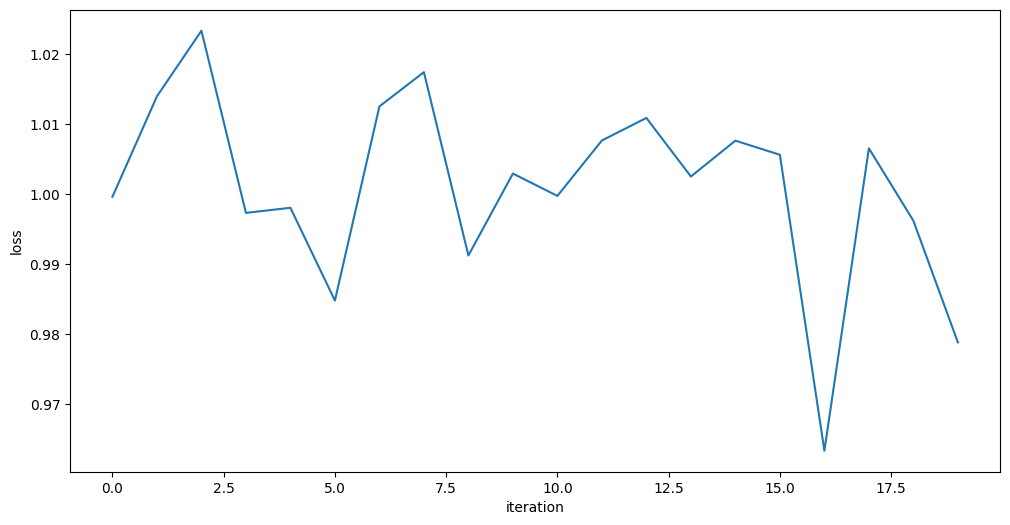

In [72]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()
